In [2]:
import pandas as pd
import spacy

nlp = spacy.load("pt_core_news_sm")

In [3]:
corpus = pd.read_json('../articles/corpus/corpus.json', lines=True)

In [4]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eduardoferreira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/eduardoferreira/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
# nltk.download('stopwords', download_dir='/Users/eduardoferreira/PycharmProjects/NLP_Recsys/nltk_data')
# nltk.data.path.append('/Users/eduardoferreira/PycharmProjects/NLP_Recsys/')


In [7]:
# Combinar colunas de texto relevantes
corpus['texto_completo'] = corpus['resumo'] + ' ' + corpus['keywords'] + ' ' + corpus['text']


# Função de pré-processamento
def preprocess_text(text):
    if not isinstance(text, str):
        return ''

    # Converter para minúsculas
    text = text.lower()

    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remover números
    text = ''.join([i for i in text if not i.isdigit()])

    # Remover stopwords
    stop_words = set(stopwords.words('portuguese'))  # assumindo que o idioma é português
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]

    return ' '.join(words)


# Aplicar pré-processamento
corpus['texto_processado'] = corpus['texto_completo'].apply(preprocess_text)

In [8]:
# Criar vetorizador
vectorizer = CountVectorizer()

# Ajustar e transformar os dados
X = vectorizer.fit_transform(corpus['texto_processado'])

# Obter o vocabulário
vocabulario_bow = vectorizer.get_feature_names_out()

print(f"Tamanho do vocabulário BoW: {len(vocabulario_bow)}")
print("Exemplos de termos:", vocabulario_bow[:20])

Tamanho do vocabulário BoW: 14225
Exemplos de termos: ['aae' 'aaeexpr' 'aaes' 'aat' 'abaixo' 'abdômen' 'aberta' 'aberto'
 'abertos' 'abertura' 'abid' 'ablação' 'aborda' 'abordada' 'abordadas'
 'abordado' 'abordados' 'abordag' 'abordagem' 'abordagens']


In [9]:
# Criar vetorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer()  # ajuste conforme necessário

# Ajustar e transformar os dados
X_tfidf = tfidf_vectorizer.fit_transform(corpus['texto_processado'])

# Obter o vocabulário
vocabulario_tfidf = tfidf_vectorizer.get_feature_names_out()

print(f"Tamanho do vocabulário TF-IDF: {len(vocabulario_tfidf)}")

Tamanho do vocabulário TF-IDF: 14225


In [10]:
# Criar vocabulário manual com base em todas as palavras
all_words = ' '.join(corpus['texto_processado']).split()
word_counts = Counter(all_words)

# Definir um mínimo de frequência
min_freq = 1  # ajuste conforme necessário
vocabulario_manual = [word for word, count in word_counts.items() if count >= min_freq]

print(f"Tamanho do vocabulário manual: {len(vocabulario_manual)}")

Tamanho do vocabulário manual: 14456


In [11]:
### Estatística do corpus
from nltk.tokenize import word_tokenize, sent_tokenize


def count_pos_tag(text: str):
    '''
    Count the number of nouns, verbs and prepositions in a pt-br.
    :param text:
    :return:
    '''
    doc = nlp(text)
    counts = {'nouns': 0, 'verbs': 0, 'prepositions': 0}

    for tok in doc:
        if tok.pos_ in ('NOUN', 'PROPN'):  # common & proper nouns
            counts['nouns'] += 1
        elif tok.pos_ == 'VERB':  # verbs
            counts['verbs'] += 1
        elif tok.pos_ == 'ADP':  # adpositions
            counts['prepositions'] += 1

    return counts


len_sentences = []
for _, paper in corpus.iterrows():
    text = sent_tokenize(paper['texto_completo'], language='portuguese')
    len_sentences.append(len(text))



In [12]:
## adiciona qtd de tokens e sentences
corpus['len_tokens'] = corpus['artigo_tokenizado'].apply(lambda x: len(x))
corpus['len_sentences'] = len_sentences

In [13]:
counts = []
for _, paper in corpus.iterrows():
    counts.append(count_pos_tag(paper['texto_completo']))

In [15]:
temp_df = pd.DataFrame(counts)
corpus['nouns'] = temp_df['nouns']
corpus['verbs'] = temp_df['verbs']
corpus['prepositions'] = temp_df['prepositions']

In [16]:
corpus.loc[0]['text']

"Introdução O reconhecimento das emoções é uma parte intrínseca das relações humanas. Mesmo na primeira infância, as crianças aprendem a mapear e interpretar: Anais do Simpósio Brasileiro sobre Multimídia e da Web (WebMe DIA'2024). Juiz de Fora, Brasil. Porto Alegre: Brasilian Computer Society, 2024. © 2024 SBC - Brasilian Computing Society. ISSN 2966-2753 Leandro Persona Fernando Meloni leandro.personA@alumni.usp.br melonifernando@yahoo.com.br Universidade de São Paulo, Ffclrp, DCM, Ppg-Ca RibE, São Paulo, Brasil, Octações de outros, outros, outras, emoções, outros, o DCM. O mapeamento é possível porque os humanos normalmente traduzem suas emoções em movimentos físicos detectáveis, particularmente expressões faciais, que são vitais para interações sociais. As expressões faciais são comportamentos onipresentes e exibem fracas dependência de fatores culturais, como demonstrado por [13]. Assim, os mesmos pesquisadores identificaram as sete emoções universais diferentes entre as culturas:

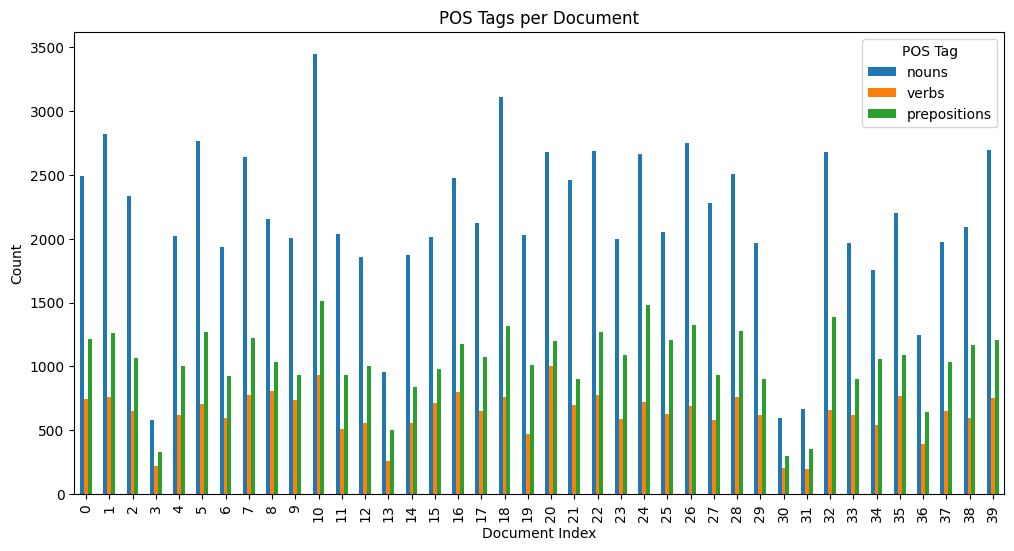

In [17]:
import matplotlib.pyplot as plt

# Select the columns to plot
pos_counts = corpus[['nouns', 'verbs', 'prepositions']]

# Create a bar chart
pos_counts.plot.bar(figsize=(12, 6))
plt.title('POS Tags per Document')
plt.xlabel('Document Index')
plt.ylabel('Count')
plt.legend(title='POS Tag')
plt.show()

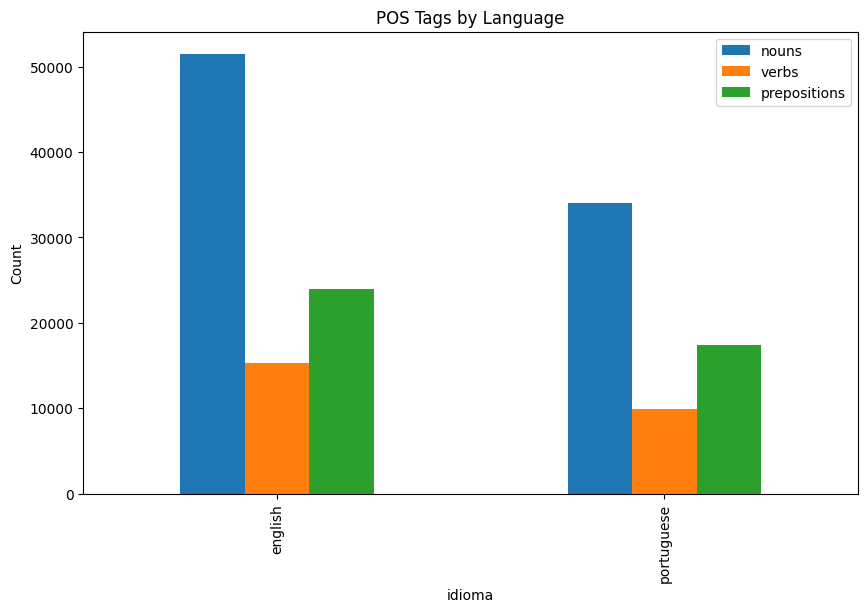

In [18]:
grouped_pos = corpus.groupby('idioma')[['nouns', 'verbs', 'prepositions']].sum()

# Plot grouped bars
grouped_pos.plot.bar(figsize=(10, 6))
plt.title('POS Tags by Language')
plt.ylabel('Count')
plt.show()

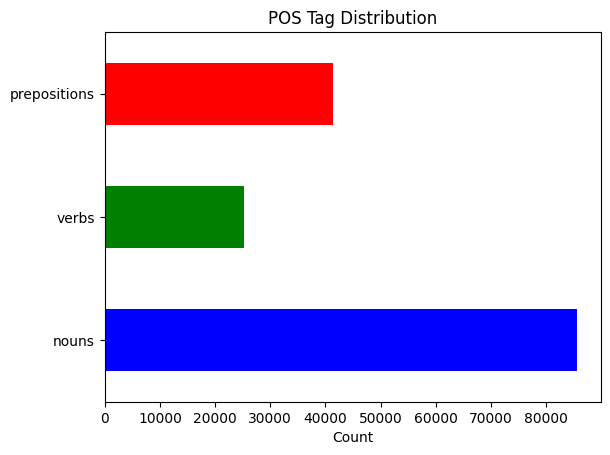

In [20]:
total_pos = pos_counts.sum()
total_pos.plot.barh(color=['blue', 'green', 'red'])
plt.title('POS Tag Distribution')
plt.xlabel('Count')
plt.show()

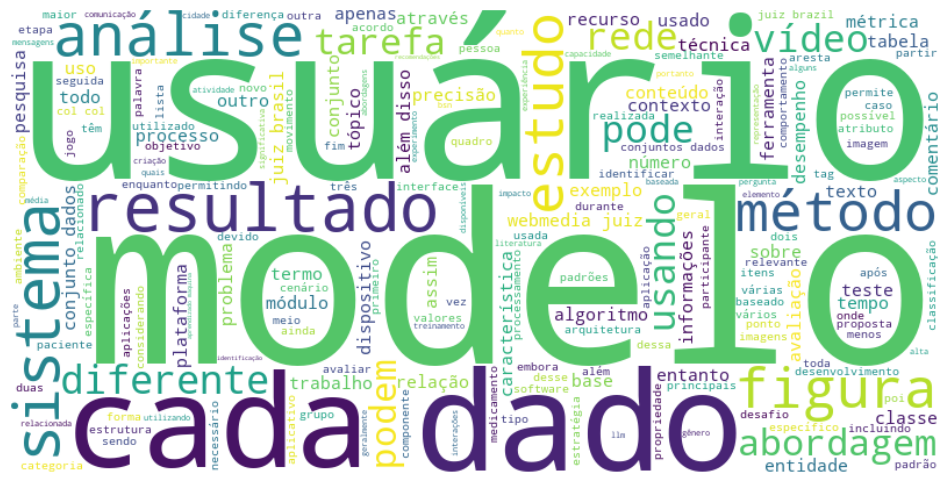

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Combine all text from your corpus
all_text = ' '.join(corpus['texto_processado'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=200,
                      colormap='viridis').generate(all_text)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [27]:
stop_words = set(stopwords.words('portuguese'))

In [28]:
def top_n_tokens(text: str, n: int = 10):
    # 1) tokenize and lowercase
    tokens = word_tokenize(text, language='portuguese')
    tokens = [t.lower() for t in tokens]
    tokens = [
        t for t in tokens
        if t.isalpha()
           and t not in stop_words
    ]
    counts = Counter(tokens)
    least = sorted(counts.items(), key=lambda x: x[1])
    return Counter(tokens).most_common(n), least[:n]

In [29]:
freq_words, lest_words = top_n_tokens(corpus['texto_processado'].loc[0])

In [44]:
freq_words = []
least_words = []
for _, paper in corpus.iterrows():
    common_word, least_word = top_n_tokens(paper['texto_processado'])
    freq_words.append(common_word)
    least_words.append(least_word)

In [45]:
corpus['freq_words'] = freq_words
corpus['least_words'] = least_words

In [46]:
corpus

,titulo,informacoes_url,idioma,storage_key,autores,data_publicacao,resumo,keywords,referencias,text,...,lema,texto_completo,texto_processado,len_tokens,len_sentences,nouns,verbs,prepositions,freq_words,least_words
0,Recognition of Emotions through Facial Geometr...,,english,../articles/original/english/985-24766-1-10-20...,"[Alessandra Alaniz Macedo, Leandro Persona, ...",11-09-2024,O reconhecimento de emoção tem um significado ...,"Multimedia Processing, Affective Computing, Ma...","[[1] Mauricio Alvarez, David Luengo, and Neil ...",Introdução O reconhecimento das emoções é uma ...,...,"[o, reconhecimento, de, emoção, ter, um, signi...",O reconhecimento de emoção tem um significado ...,reconhecimento emoção significado fundamental ...,8031,286,2492,748,1218,"[(emoções, 64), (reconhecimento, 49), (faciais...","[(significado, 1), (pois, 1), (implica, 1), (d..."
1,Enhancing widget recognition for automated And...,,english,../articles/original/english/985-24752-1-10-20...,"[Yadini Pérez López, Laís Dib Albuquerque, G...",11-09-2024,O reconhecimento de widgets é crucial para tes...,"Automated Android Testing, Test Portability, O...","[[1] A. A. Abdelhamid, S. Alotaibi, and A. Mou...",Introdução O teste automatizado de aplicativos...,...,"[o, reconhecimento, de, Widgets, ser, crucial,...",O reconhecimento de widgets é crucial para tes...,reconhecimento widgets crucial testes automati...,8746,284,2819,757,1262,"[(widgets, 81), (reconhecimento, 79), (widget,...","[(últimos, 1), (dez, 1), (anos, 1), (acadêmico..."
2,Multi-Domain Spatio-Temporal Deformable Fusion...,,english,../articles/original/english/985-24762-1-10-20...,"[Garibaldi da Silveira Júnior, Gilberto Kreisl...",11-09-2024,A compactação de vídeo com perda de imóvel int...,"Redes neurais profundas, Melhoria de qualidade...","[[1] Aayushi Agarwal, Akshay Agarwal, Sayan Si...",Introdução A compactação de vídeo desempenha u...,...,"[o, compactação, de, vídeo, com, perda, de, im...",A compactação de vídeo com perda de imóvel int...,compactação vídeo perda imóvel introduz artefa...,6996,221,2337,654,1064,"[(vídeo, 54), (qualidade, 49), (vídeos, 49), (...","[(imóvel, 1), (degradar, 1), (mitigar, 1), (pr..."
3,Finding Fake News Websites in the Wild,,english,../articles/original/english/985-24756-1-10-20...,"[Leandro Araujo, João M. M. Couto, Luiz Feli...",11-09-2024,A batalha contra a disseminação de informações...,"Fake News, Misinformation, Credibility, Websit...","[[1] Leandro Araújo, Luiz Felipe Nery, Isadora...","Introdução Nos últimos tempos, a sociedade enf...",...,"[o, batalha, contra, o, disseminação, de, info...",A batalha contra a disseminação de informações...,batalha contra disseminação informações errada...,1996,73,580,220,330,"[(sites, 36), (notícias, 31), (falsas, 23), (d...","[(batalha, 1), (internet, 1), (assustadora, 1)..."
4,Tagging Enriched Bank Transactions Using LLM-G...,,english,../articles/original/english/985-24767-1-10-20...,"[Daniel de S. Moraes, Polyana B. da Costa, P...",11-09-2024,Este trabalho apresenta um método não supervis...,"Large Language Models, Natural Language Proces...","[[1] Rohan Anil, Sebastian Borgeaud, Yonghui W...",Introdução Muitos estudos recentes se concentr...,...,"[este, trabalho, apresentar, um, método, não, ...",Este trabalho apresenta um método não supervis...,trabalho apresenta método supervisionado marca...,6455,238,2026,621,1001,"[(taxonomias, 70), (termos, 61), (taxonomia, 4...","[(marcar, 1), (construído, 1), (expandido, 1),..."
5,Fast ISP Mode Decision for the Versatile Video...,,english,../articles/original/english/985-24755-1-10-20...,"[Larissa Araújo, Adson Duarte, Bruno Zatt, ...",11-09-2024,O padrão versátil de codificação de vídeo (VVC...,"VVC, Intra Prediction, ISP, Machine Learning",[[1] James Bergstra and Yoshua Bengio. 2012. R...,Introdução Os vídeos digitais têm sido fundame...,...,"[o, padrão, versátil, de, codificação, de, víd...",O padrão versátil de codificação de vídeo (VVC...,padrão versátil codificação

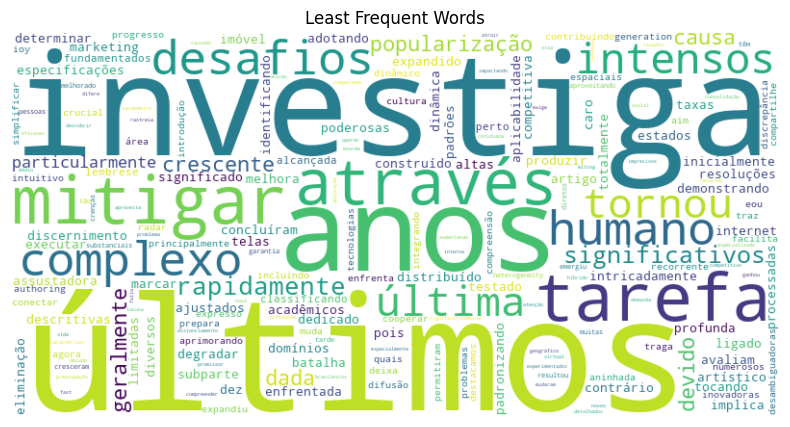

In [61]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 1: Aggregate all word counts from all rows
least_freq_dict = Counter()
for row in corpus['least_words']:
    least_freq_dict.update(dict(row))

# Step 2: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(least_freq_dict)

# Step 3: Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Least Frequent Words")
plt.show()


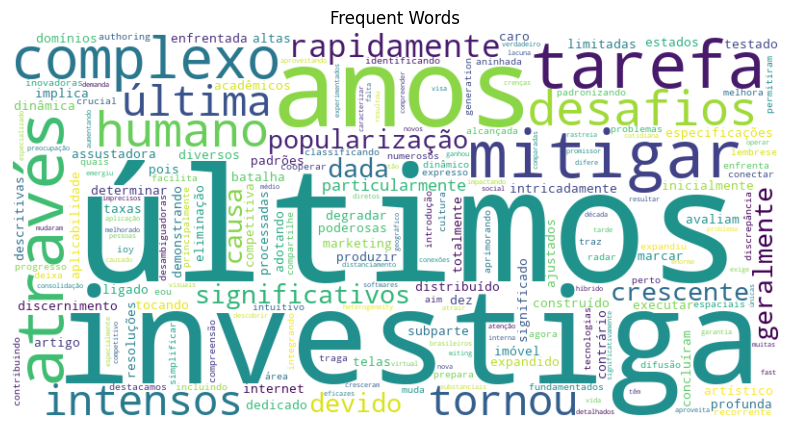

In [63]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 1: Aggregate all word counts from all rows
common_freq_dict = Counter()
for row in corpus['freq_words']:
    common_freq_dict.update(dict(row))

# Step 2: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(least_freq_dict)

# Step 3: Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Frequent Words")
plt.show()
